In [1]:
import pandas as pd 
import numpy as np

import csv

In [2]:
listingDf = pd.read_csv('./Data/listings.csv')
reviewsDf = pd.read_csv('./Data/reviews.csv')

In [3]:
listingDf.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,27966,https://www.airbnb.com/rooms/27966,20211028170327,2021-10-29,Heraklion-Pinelopi Apartment,For an unforgettable stay!! Just 10 minutes wa...,Ammoudara is a very cute area with lots of bea...,https://a0.muscache.com/pictures/b8e0ecb1-c444...,120502,https://www.airbnb.com/users/show/120502,...,4.99,4.60,4.91,00000247117,t,2,2,0,0,1.35
1,28970,https://www.airbnb.com/rooms/28970,20211028170327,2021-10-28,artists' house in the old town,This is a fully renovated stone house from 191...,its calm with many old ladies that adooooore s...,https://a0.muscache.com/pictures/25900225/f18f...,124670,https://www.airbnb.com/users/show/124670,...,4.96,4.51,4.51,00000353067,f,2,2,0,0,0.42
2,29130,https://www.airbnb.com/rooms/29130,20211028170327,2021-10-29,"Villa Kallergi - Athena, 640m²",Villa Athena Kallergi in the heart of the Cret...,The traditional village of Loutra was chosen t...,https://a0.muscache.com/pictures/7a38ebf6-9a7b...,125281,https://www.airbnb.com/users/show/125281,...,4.56,4.67,4.78,2512208,f,3,3,0,0,0.34
3,29849,https://www.airbnb.com/rooms/29849,20211028170327,2021-10-29,"Villa Kallergi - Nefeli, 6 guests",Villa Nefeli Kallergi with private pool in the...,The traditional village of Loutra was chosen t...,https://a0.muscache.com/pictures/46608920/8497...,125281,https://www.airbnb.com/users/show/125281,...,5.00,4.67,4.83,2539344,f,3,3,0,0,0.15
4,29856,https://www.airbnb.com/rooms/29856,20211028170327,2021-10-29,Matala Dimitris Villa - Four Bed Room,"Dimitris Villa Hotel consists of 20 rooms, whi...",only 350 m from the Center make our place idea...,https://a0.muscache.com/pictures/c5324bac-75f3...,128653,https://www.airbnb.com/users/show/128653,...,4.40,4.50,4.20,00001193488,t,4,0,4,0,0.45


In [ ]:
## Ce ar fi interesant de aflat - AirBnb Malta
# 1. Date despre apartamente:
## 1.1 Private/ Whole apt.
## 1.2 Capacitate
## 1.3 Prices
## 1.4 Location?
## 1.5 Scores
## 1.6 Reviews - positive/neutru/negative feedback.

In [4]:
## Number of observations
len(listingDf)
## 20178 listings!

20178

In [9]:
listingDf['last_scraped'].max() ## 2021-10-31
listingDf['last_scraped'].min() ## 2021-10-28

'2021-10-28'

In [10]:
## Check of duplicates
listingDf['id'].duplicated().any()
## 'id' row doesn't contain duplicates

listingDf['host_id'].duplicated().any()
## we have duplicates here. this means that a number of people owns several properties


True

In [66]:
reviewsDf.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [65]:
listingDf.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 74, dtype: object

In [11]:
listingDf['host_id'].duplicated(keep='first').sum()
## 11.541 owners vs. 20.178 places listed

11541

In [20]:
colnames_listingDf = np.array(listingDf.columns)
df_colnames1 = pd.DataFrame(data=colnames_listingDf)
df_colnames1 = df_colnames1.rename(columns = {0: 'Colname'}, inplace=False)

In [12]:
reviewsDf.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,47974168,408468040499676026,2021-07-17,329255817,Amber,Great location. Finn was very kind and very he...
1,47974168,420066568784346988,2021-08-02,85242454,Agata,"Very well located, clean, and brand new apartm..."
2,47974168,442507449738983902,2021-09-02,208876800,Tooba,We had a great stay at this Airbnb. Ideal loca...
3,47974168,454772815408678119,2021-09-19,282761842,Konstantin,"Very nice apartment, great kitchen with everyt..."
4,47974168,458508331343668440,2021-09-24,72082789,Marek,The place is consistent with the description a...


In [21]:
## select columns related to reviews from the first df 
reviews_cols = [col for col in listingDf.columns if 'review' in col]
print(reviews_cols)


['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [25]:
## create df with id and reviews colnames
reviewsDf2 = listingDf.filter(regex='review|id')

In [ ]:
## thought of joining them, but we have multiple reviews on the same propriety

In [50]:
#df = reviewsDf.groupby('listing_id')['comments'].nunique()
## max comments no. = 425
## min comments no. = 1

## nunique returns a series. agg returns a df
df = reviewsDf.groupby('listing_id').agg({'comments': pd.Series.nunique}) ##6428

In [36]:
df['comments'].mean() ## around 26 reviews.

26.437305538270067

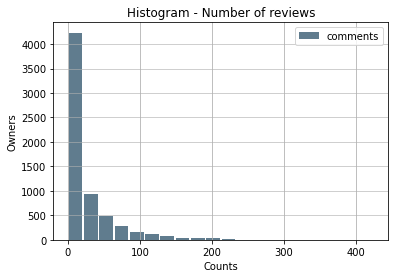

In [41]:
import matplotlib.pyplot as plt

# Generate data on commute times.
size, scale = 1000, 10
#commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

df.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram - Number of reviews')
plt.xlabel('Counts')
plt.ylabel('Owners')
plt.grid(axis='y', alpha=0.75)

In [42]:
## select homes with >= 50 reviews
df = df[df.comments >= 50] ##1063

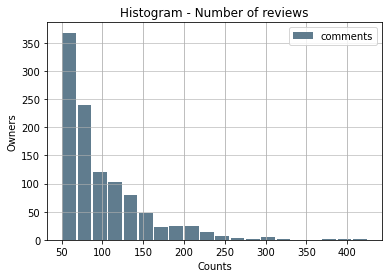

In [43]:
# Generate data on commute times.
size, scale = 1000, 10
#commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

df.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram - Number of reviews')
plt.xlabel('Counts')
plt.ylabel('Owners')
plt.grid(axis='y', alpha=0.75)

In [51]:
## listing_id converted from index to column
df['listing_id'] = df.index

In [53]:
df.columns

Index(['comments', 'listing_id'], dtype='object')

In [ ]:
ids = df['listing_id'].to_list()
#print(f"\nids:\n{ids}\ntype:{type(ids)}")

In [59]:
## select only the listings in the array
sampleReviews = reviewsDf[reviewsDf.listing_id.isin(ids)]

In [64]:
sampleReviews = reviewsDf[reviewsDf['listing_id'].isin([50188, 102120])]

In [63]:
len(sampleReviews)

170069